# Прогнозирование оттока клиентов сети фитнес-центров

## Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных для снижения их оттока. <br>
Чтобы бороться с оттоком клиентов, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.<br>
Задачи:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
      1) выделить целевые группы клиентов;
      2) предложить меры по снижению оттока;
      3) определить другие особенности взаимодействия с клиентами.

## Описание данных

Фитнес-центр предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. <br>
Набор данных включает следующие поля:<br>
Данные клиента за предыдущий до проверки факта оттока месяц:
- *gender* — пол;
- *Near_Location* — проживание или работа в районе, где находится фитнес-центр;
- *Partner* — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент  в таком случае фитнес-центр хранит информацию о работодателе клиента);
- *Promo_friends* — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- *Phone* — наличие контактного телефона;
- *Age* — возраст;
- *Lifetime* — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- *Contract_period* — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- *Month_to_end_contract* — срок до окончания текущего действующего абонемента (в месяцах);
- *Group_visits* — факт посещения групповых занятий;
- *Avg_class_frequency_total* — средняя частота посещений в неделю за все время с начала действия абонемента;
- *Avg_class_frequency_current_month* — средняя частота посещений в неделю за предыдущий месяц;
- *Avg_additional_charges_total* — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- *Churn* — факт оттока в текущем месяце.

## План проекта

1. Загрузка и предобработка данных.
2. Исследовательский анализ данных (EDA).
3. Модель прогнозирования оттока клиентов.
4. Кластеризацию клиентов.
5. Общие выводы и рекомендации по работе с клиентами.

## Загрузка и предобработка данных

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from plotly import graph_objects as go


from scipy.cluster.hierarchy import dendrogram, linkage 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score, 
    f1_score, 
    roc_auc_score, 
    silhouette_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [2]:
import warnings
warnings.filterwarnings('ignore')

# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.3f}'.format

In [3]:
try:
    df = pd.read_csv('/datasets/gym_churn.csv')
except:
    df = pd.read_csv('C:/Users/888/OneDrive/Рабочий стол/ML/gym_churn.csv')

Выведем основную информацию о датафрейме:

In [4]:
# напишем функцию для обзора данных:
def print_primary_info(df):
    print("\nПервичная информация о датафрейме")
    print("Количество записей:", df.shape[0])
    print("Количество столбцов:", df.shape[1])
    print("\nПервые 10 строк:")
    display(df.head(10))
    print("Информация о типах данных: \n")
    print(df.info())
    print("\nПропуски:")
    display(df.isna().sum())
    print("Процент пропусков от всего датафрейма:")
    display(df.isna().mean().sort_values(ascending=False)*100)
    print("Дубликаты:")
    if df.duplicated().sum() > 0:
        print('Дубликатов: ', df.duplicated().sum())
    else:
        print('Дубликатов НЕТ')  

In [5]:
print_primary_info(df)


Первичная информация о датафрейме
Количество записей: 4000
Количество столбцов: 14

Первые 10 строк:


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227,5.000,3,0.020,0.000,0
1,0,1,0,0,1,12,1,31,113.203,12.000,7,1.923,1.910,0
2,0,1,1,0,1,1,0,28,129.448,1.000,2,1.859,1.737,0
3,0,1,1,1,1,12,1,33,62.670,12.000,2,3.206,3.357,0
4,1,1,1,1,1,1,0,26,198.362,1.000,3,1.114,1.120,0
5,1,1,0,0,1,1,1,34,450.744,1.000,3,2.623,2.637,0
6,1,1,1,1,0,6,1,32,94.266,6.000,2,1.139,1.277,0
7,0,1,0,0,1,1,0,30,217.787,1.000,0,1.214,1.049,1
8,1,1,1,1,1,1,1,23,45.410,1.000,1,1.106,1.059,0
9,0,1,0,0,1,1,0,31,65.311,1.000,11,1.811,1.951,0


Информация о типах данных: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total  

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Процент пропусков от всего датафрейма:


gender                              0.000
Near_Location                       0.000
Partner                             0.000
Promo_friends                       0.000
Phone                               0.000
Contract_period                     0.000
Group_visits                        0.000
Age                                 0.000
Avg_additional_charges_total        0.000
Month_to_end_contract               0.000
Lifetime                            0.000
Avg_class_frequency_total           0.000
Avg_class_frequency_current_month   0.000
Churn                               0.000
dtype: float64

Дубликаты:
Дубликатов НЕТ


### Предобработка

Название столбцов приведем к нижнему регистру.

In [6]:
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

В столбце 'month_to_end_contract' применяются только целочисленные значения. Изменим тип на *int* :

In [7]:
df['month_to_end_contract'].unique()

array([ 5., 12.,  1.,  6.,  3., 10., 11.,  9.,  4.,  7.,  8.,  2.])

In [8]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')

In [9]:
#проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

### Вывод

- В данных содержится 4000 записи в 14 столбцах.
- Пропуски и дубликаты отсутвуют.
- Привели названия столбцов к нижнему регистру.
- В столбце *month_to_end_contract* поменяли тип данных.
- Данные полные и достаточны для исследования.

## Исследовательский анализ данных (EDA)

###  Средние значения признаков

Посмотрим общую информацию о данных.

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,"4,000.000",0.510,0.500,0.000,0.000,1.000,1.000,1.000
near_location,"4,000.000",0.845,0.362,0.000,1.000,1.000,1.000,1.000
partner,"4,000.000",0.487,0.500,0.000,0.000,0.000,1.000,1.000
promo_friends,"4,000.000",0.308,0.462,0.000,0.000,0.000,1.000,1.000
phone,"4,000.000",0.903,0.295,0.000,1.000,1.000,1.000,1.000
contract_period,"4,000.000",4.681,4.550,1.000,1.000,1.000,6.000,12.000
group_visits,"4,000.000",0.412,0.492,0.000,0.000,0.000,1.000,1.000
age,"4,000.000",29.184,3.258,18.000,27.000,29.000,31.000,41.000
avg_additional_charges_total,"4,000.000",146.944,96.356,0.148,68.869,136.220,210.950,552.591
month_to_end_contract,"4,000.000",4.323,4.191,1.000,1.000,1.000,6.000,12.000


По данным можно сказать следующее:
- **gender** - мужчин и женщин в данных примерно поровну;
- **near_location** - большинство клиентов 84.5% проживают или работают в районе нахождения фитнес-центра;
- **partner** - почти половино клиентов это сотрудники компаний-партнеров клуба;
- **promo_friends** - почти треть клиентов пришли по акции «приведи друга»;
- **phone** - 10% клиентов не указали номер контактного телефона;
- **contract_period** - половино клиентов имеют действующий абонемент на 1 месяц и четверть клиентов 6-12 месяцев;
- **group_visits** - груповые занятия посещают примерно 40% клиентов;
- **age** - возраст клиентов от 18 до 41, но половино клиентов в возрасте 29 лет;
- **avg_additional_charges_total** - средняя суммарная выручка от дополнительных услуг 147 денежных едениц;
- **month_to_end_contract** -  срок до окончания текущего действующего абонемента у половины клиентов составляет 1 месяц;
- **lifetime** -  время с момента первого обращения клиента в фитнес-центр от 1 до 31 месяца и у половины клиентов составляет 3 месяца;
- **avg_class_frequency_total** - средняя частота посещения 2 раза в неделю, но есть кто посещает 6 раз в неделю;
- **avg_class_frequency_current_month** - средняя частота посещения за прошедший месяц так же 2 раза в неделю;
- **churn** - текущий отток клиентов 26.5%.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуемся методом groupby())

In [11]:
df.groupby('churn').mean().T

churn,0,1
gender,0.510,0.511
near_location,0.873,0.768
partner,0.534,0.355
promo_friends,0.354,0.184
phone,0.904,0.903
contract_period,5.747,1.729
group_visits,0.464,0.269
age,29.977,26.990
avg_additional_charges_total,158.446,115.083
month_to_end_contract,5.283,1.663


Вывод по двум группам (0-остался, 1-ушёл):
- **gender** - пол не влияет на отток;
- **near_location** - этот признак не существенно влияет на отток клиентов, у ушедших клиентов на 10% больше клиентов из других районов;
- **partner** - сотрудники компаний-партнеров клуба более лояльны к центру;
- **promo_friends** - так же клиенты пришедшие по акции «приведи друга» более лояльны;
- **phone** - наличие телефона никак не влияет на отток;
- **contract_period** - среди оставшихся клиентов имеют действующий абонемент в среднем 6 месяцев, у ушедших 2 месяца;
- **group_visits** - почти половина оставшихся посещают групповые занятия;
- **age** - по среднему возрасту есть небольшое отличие 30 лет у оставшихся и 27 у ушедших;
- **avg_additional_charges_total** - оставшиеся клиенты больше тратят на доп. услуги;
- **month_to_end_contract** - срок до окончания абонемента у оставшихся 5 месяцев и у ушедших меньше 2 месяцев;
- **lifetime** - среднее «время жизни» клиента у оставшихся 5 месяцев, у ушедших меньше месяца;
- **avg_class_frequency_total** - среднее количество посещений у ушедших 1-2 раза в месяц, у оставшихся 2 раза;
- **avg_class_frequency_current_month** - среднее количество посещений в неделю за прошедший месяц у оставшихся - 2 раза, у ушедших - 1 раз.

### Столбчатые гистограммы и распределения признаков

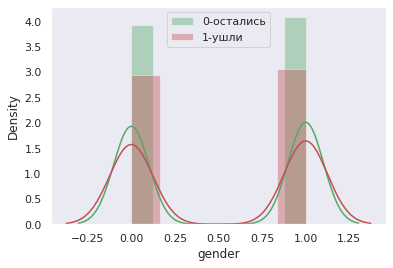

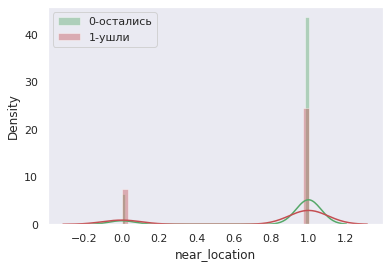

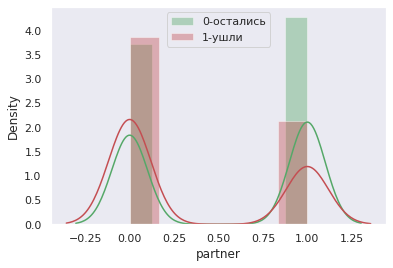

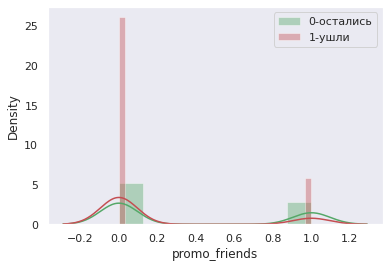

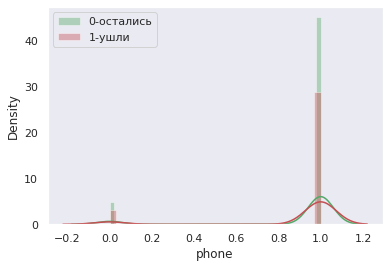

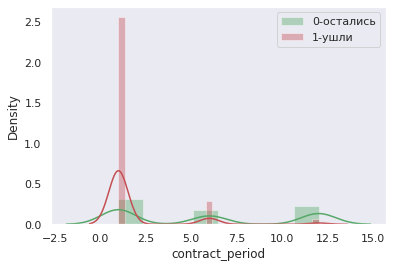

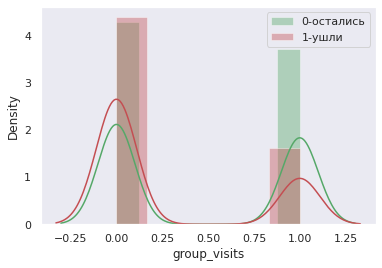

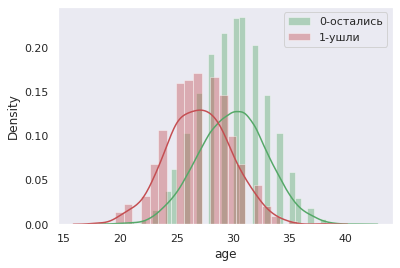

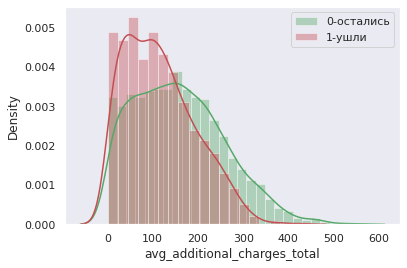

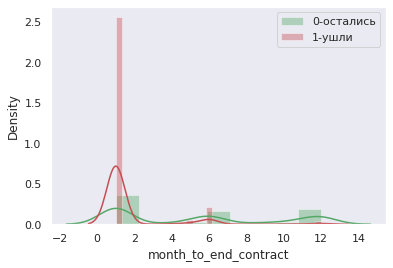

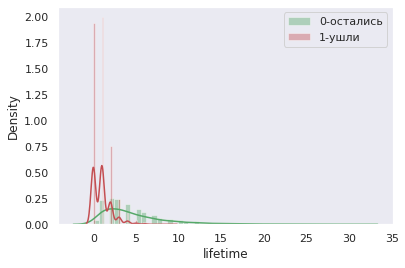

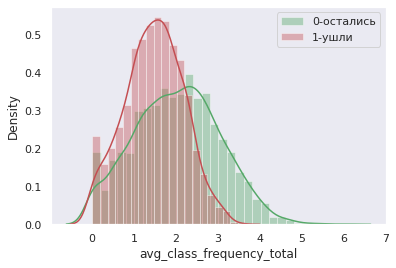

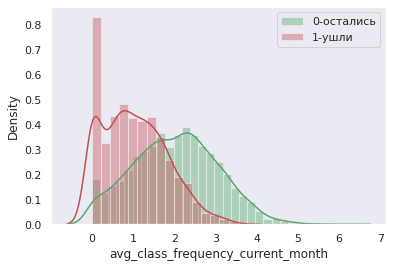

In [12]:
sns.set()
fig, ax_lst = plt.subplots(1, 1)

for i in df.drop('churn', axis=1).columns:
    sns.distplot(df.loc[df['churn'] == 0, i], label='0-остались', color='g')
    sns.distplot(df.loc[df['churn'] == 1, i], label='1-ушли', color='r')
    plt.grid()
    plt.legend()
    plt.show()

Графики визуализируют и подтверждают выводы сделанные выше:
- **gender** - пол не влияет на отток;
- **near_location** - этот признак не существенно влияет на отток клиентов, у ушедших клиентов на 10% больше клиентов из других районов;
- **partner** - сотрудники компаний-партнеров клуба более лояльны к центру;
- **promo_friends** - так же клиенты пришедшие по акции «приведи друга» более лояльны;
- **phone** - наличие телефона никак не влияет на отток;
- **contract_period** - среди оставшихся клиентов имеют действующий абонемент в среднем 6 месяцев, у ушедших 2 месяца;
- **group_visits** - почти половина оставшихся посещают групповые занятия;
- **age** - по среднему возрасту есть небольшое отличие 30 лет у оставшихся и 27 у ушедших;
- **avg_additional_charges_total** - оставшиеся клиенты больше тратят на доп. услуги;
- **month_to_end_contract** - срок до окончания абонемента у оставшихся 5 месяцев и у ушедших меньше 2 месяцев;
- **lifetime** - среднее «время жизни» клиента у оставшихся 5 месяцев, у ушедших меньше месяца;
- **avg_class_frequency_total** - среднее количество посещений у ушедших 1-2 раза в месяц, у оставшихся 2 раза;
- **avg_class_frequency_current_month** - среднее количество посещений в неделю за прошедший месяц у оставшихся - 2 раза, у ушедших - 1 раз.

### Матрица корреляций

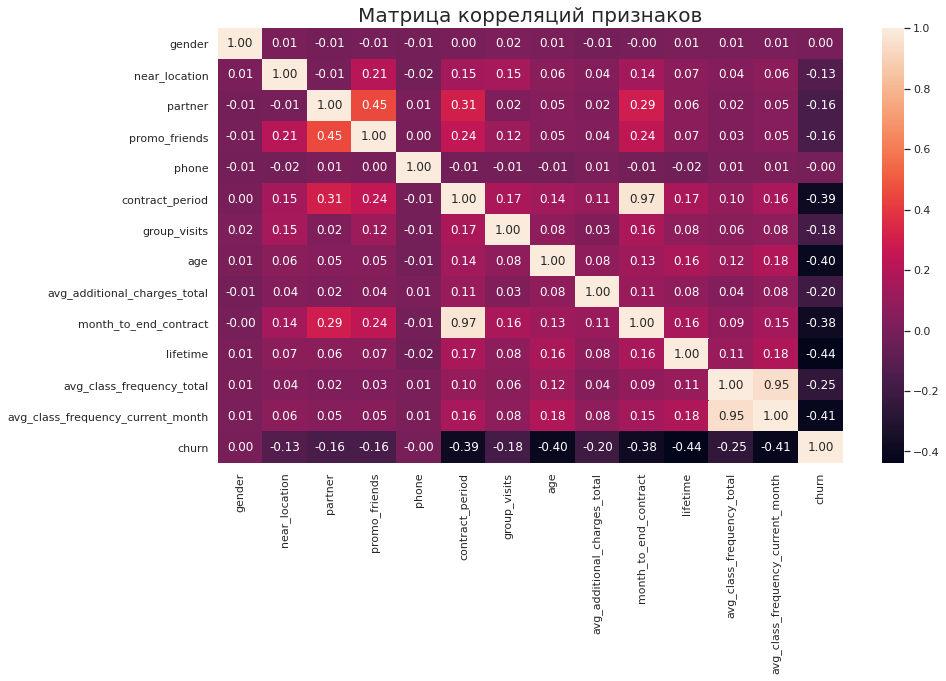

In [13]:
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(), annot = True, square=False, fmt = '0.2f')
plt.title('Матрица корреляций признаков', fontsize = 20)
plt.show()

- Признаки имеют отрицательную кореляцию с целевой переменной *churn*.
- Имеется две пары признаков которые сильно коррелируют между собой: *month_to_end_contract* - *contract_period* и *avg_class_frequency_total* - *avg_class_frequency_current_month*. При построении модели прогнозирования наличие коррелирующих признаков нежелательно.

Удаляем один из коррелирующих в паре признаков:

In [14]:
df_model = df.drop('avg_class_frequency_total', axis=1)
df_model = df.drop('month_to_end_contract', axis=1)

### Вывод

- Мы провели исследовательский анализ EDA.
- Проаназировали признаки и группы оставшиеся-ушедшие.
- Выявили признаки не влияющие на отток: пол и наличие телефона в анкете.
- Выявили сильно коррелируют между собой пары признаков. Удалили один из признаков в паре.
- Признаков коррелирующих с целевой переменной нет.

## Модель прогнозирования оттока клиентов

### Разделение данных на обучающую и валидационную выборку

In [15]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df_model.drop('churn', axis=1)
y = df_model['churn'] 

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
#о бучаем scaler и трансформируем матрицу для обучающей выборки
X_train_st = scaler.fit_transform(X_train)
# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

### Обучение модели на train-выборке двумя способами

Обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом.

In [16]:
# задаем алгоритм для модели
# Логистическая регрессия:
model_LR = LogisticRegression(solver='liblinear', random_state=0)
# обучение модели
model_LR.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions_LR =  model_LR.predict(X_test_st)
probabilities_LR = model_LR.predict_proba(X_test_st)[:,1]

# Случайный лес:
model_RF = RandomForestClassifier(random_state=0)
model_RF.fit(X_train_st, y_train)
predictions_RF =  model_RF.predict(X_test_st)
probabilities_RF = model_RF.predict_proba(X_test_st)[:,1]

### Оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке

In [17]:
print ('Значениея метрик для модели логистической регресси:')
print ('Доля правильных ответов: accuracy = ', round(accuracy_score(y_test, predictions_LR), 2))
print ('Точность: precision = ', round(precision_score(y_test, predictions_LR), 2))
print ('Полнота: recall = ', round(recall_score(y_test, predictions_LR), 2))

Значениея метрик для модели логистической регресси:
Доля правильных ответов: accuracy =  0.92
Точность: precision =  0.85
Полнота: recall =  0.83


In [18]:
print ('Значениея метрик для модели случайный лес:')
print ('Доля правильных ответов: accuracy = ', round(accuracy_score(y_test, predictions_RF), 2))
print ('Точность: precision = ', round(precision_score(y_test, predictions_RF), 2))
print ('Полнота: recall = ', round(recall_score(y_test, predictions_RF), 2))

Значениея метрик для модели случайный лес:
Доля правильных ответов: accuracy =  0.91
Точность: precision =  0.83
Полнота: recall =  0.81


### Вывод

На этом этапе:
- Разделили данные на обучающую и валидационную выборку функцией *train_test_split()*.
- Обучили модель на train-выборке двумя способами:
       1)логистической регрессией,
       2)случайным лесом.
- Оценили метрики accuracy, precision и recall для обеих моделей на валидационной выборке.

Обе модели показали себя неплохо. Но модель *логистической регресси* немного лучше.

## Кластеризацию клиентов

Отбросим столбец *'churn'* и стандартизируем данные

In [19]:
x = df.drop('churn', axis = 1)

# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
x_sc = sc.fit_transform(x)

### Матрица расстояний и дендрограмма

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

In [20]:
linked = linkage(x_sc, method = 'ward')

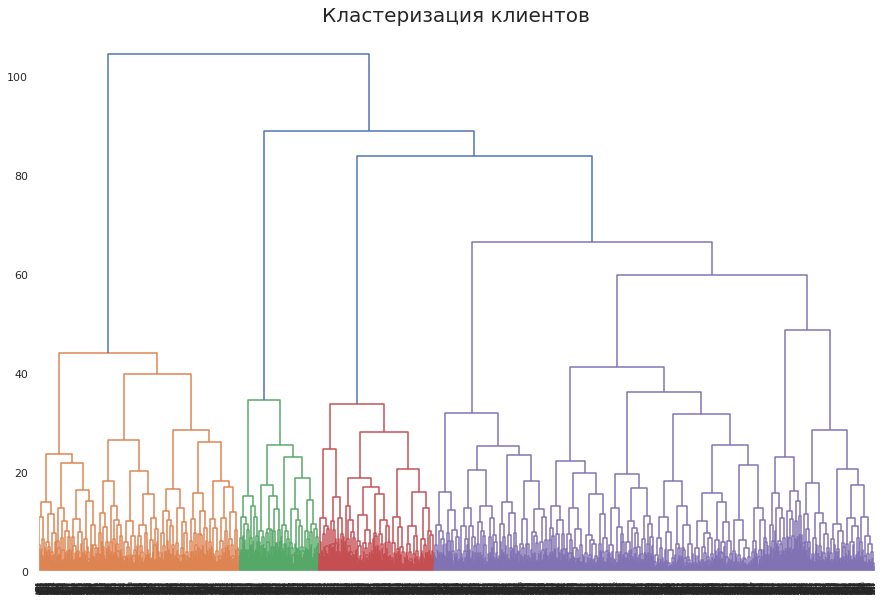

In [21]:
# строим дендрограмму:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов', fontsize = 20)
plt.show()

Согласно дендрограмме данные можно разделить на 4 - 6 кластеров. Согласно задачи поделим на 5 кластеров.

### Обучим модель кластеризации на основании алгоритма K-Means

In [22]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters = 5, random_state=0) 
# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(x_sc)
# добавляем в исходные данные метки с номерами кластеров
df['cluster'] = labels

df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster
0,1,1,1,1,0,6,1,29,14.227,5,3,0.020,0.000,0,1
1,0,1,0,0,1,12,1,31,113.203,12,7,1.923,1.910,0,0
2,0,1,1,0,1,1,0,28,129.448,1,2,1.859,1.737,0,3
3,0,1,1,1,1,12,1,33,62.670,12,2,3.206,3.357,0,0
4,1,1,1,1,1,1,0,26,198.362,1,3,1.114,1.120,0,3


Посмотрим сколько клиентов в каждом кластере:

In [23]:
df.groupby('cluster')['gender'].count()

cluster
0    1010
1     385
2     505
3    1262
4     838
Name: gender, dtype: int64

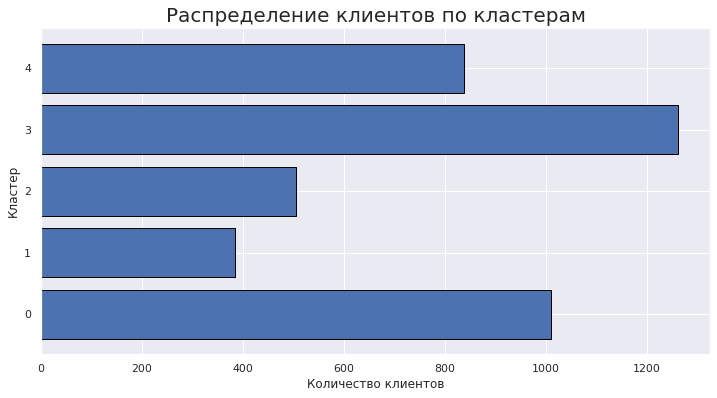

In [24]:
df.groupby('cluster')['gender'].count().plot(figsize=(12, 6), kind = 'barh', width=0.8, ec='black');
plt.title('Распределение клиентов по кластерам', size=20)
plt.ylabel('Кластер', size=12)
plt.xlabel('Количество клиентов', size=12)
plt.show()

Средние значения метрик для каждого кластера:

In [25]:
df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.503,0.522,0.495,0.486,0.560
near_location,0.959,0.862,0.000,1.000,0.976
partner,0.783,0.470,0.463,0.350,0.357
promo_friends,0.574,0.306,0.079,0.240,0.230
phone,1.000,0.000,1.000,1.000,0.999
contract_period,10.889,4.787,2.352,1.948,2.669
group_visits,0.543,0.426,0.216,0.342,0.474
age,29.982,29.301,28.477,28.168,30.125
avg_additional_charges_total,160.761,143.958,135.458,131.622,161.658
month_to_end_contract,9.954,4.475,2.198,1.857,2.459


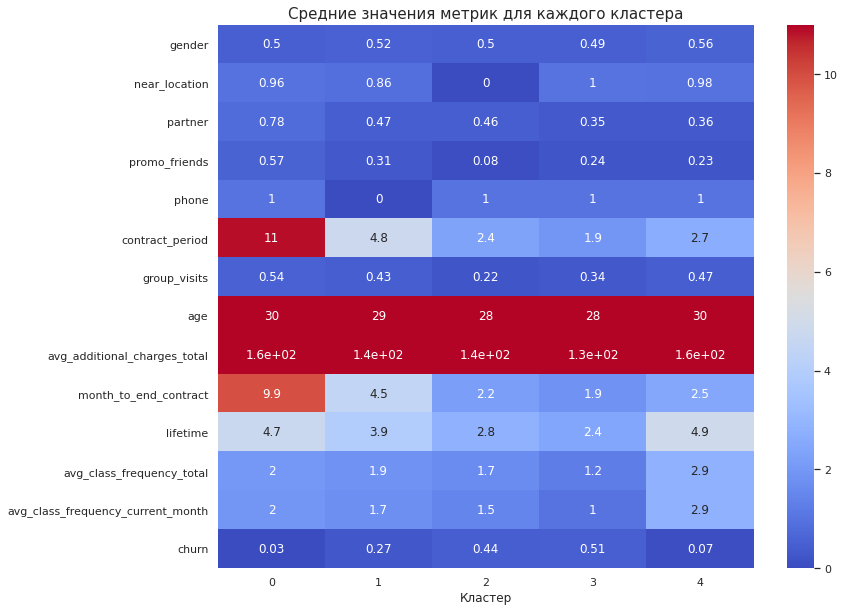

In [26]:
plt.figure(figsize = (12, 10))
sns.heatmap(round(df.groupby('cluster').mean().T, 2), vmin=0, vmax=11, cmap='coolwarm', annot=True)
plt.title('Средние значения метрик для каждого кластера', size=15)
plt.xlabel('Кластер', size=12)
plt.show()

### Распределения признаков для кластеров

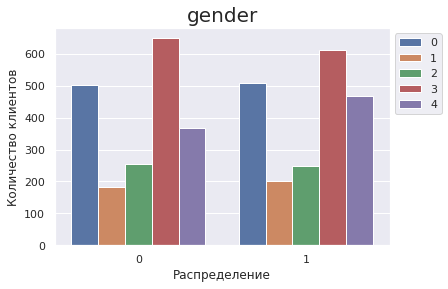

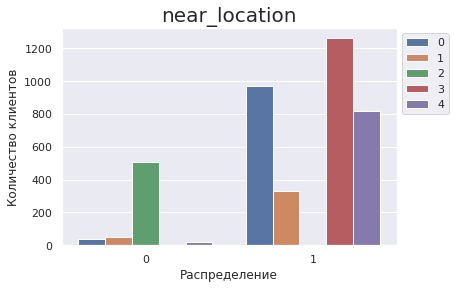

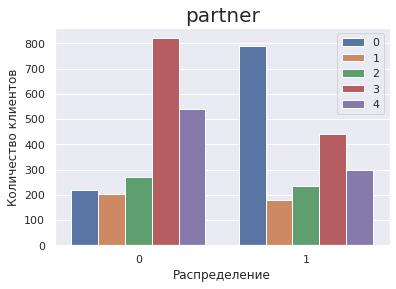

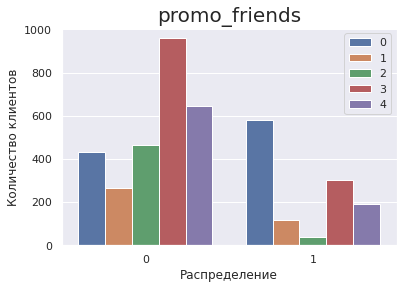

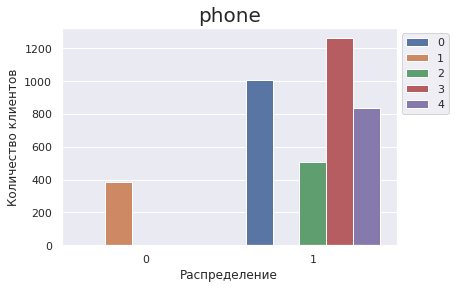

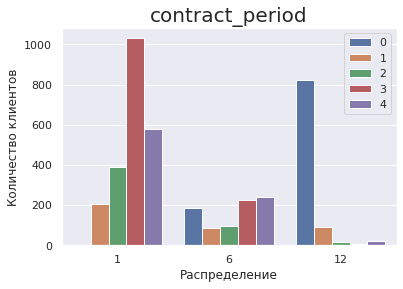

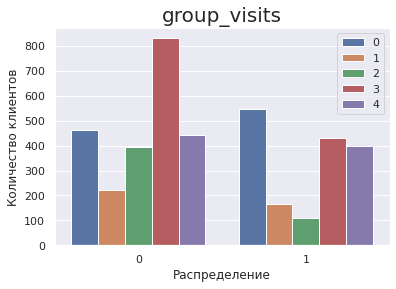

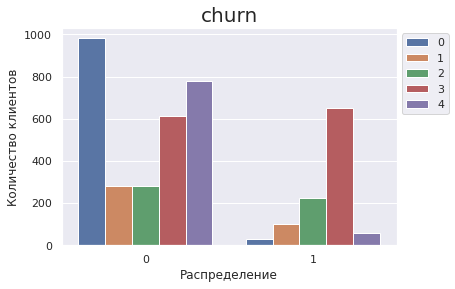

In [27]:
# Построим график
values = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period','group_visits', 'churn']
for column in values:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x = df[column], hue='cluster')
    plt.xlabel('Распределение')
    plt.ylabel('Количество клиентов')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title(column, size=20)
    plt.show()

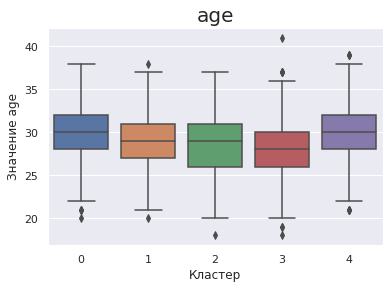

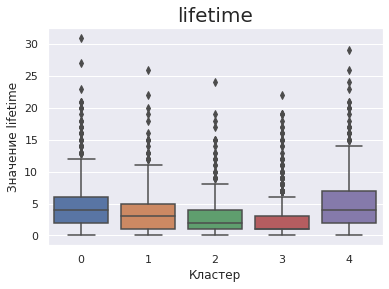

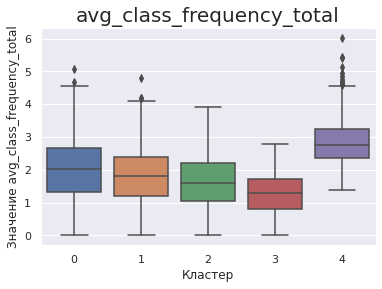

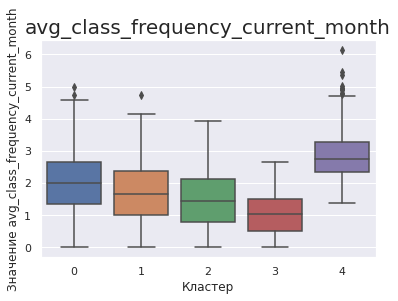

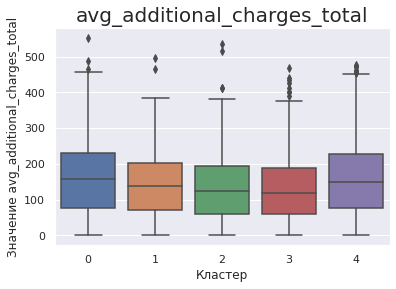

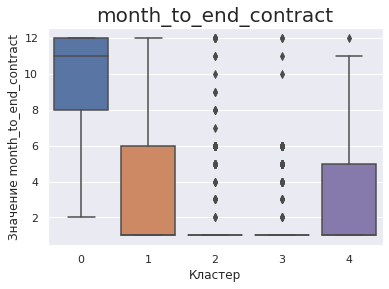

In [28]:
values = ['age', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'avg_additional_charges_total',\
         'month_to_end_contract']
for column in values:
    plt.figure(figsize=(6, 4))
    plt.title(column)
    sns.boxplot(data=df, x='cluster', y=column)
    plt.title(column, size=20)
    plt.xlabel('Кластер')
    plt.ylabel('Значение '+column)
    plt.show()

**Анализ клиентских кластеров фитнес-центра**

**Кластер 0:**
- Размер: Второй по величине, 1010 клиентов.
- Особенности: Большое количество клиентов-партнеров (78%) и длительный срок абонемента.
- Посещаемость групповых занятий: 54% клиентов посещают групповые занятия.
- Лояльность: Самый лояльный кластер с оттоком всего 3%.

**Кластер 1:**
- Размер: Самый немногочисленный, 385 клиентов.
- Особенности: Находится в золотой середине по всем признакам.
- Телефонные данные: Клиенты не оставили номер телефона в анкете.
- Отток: Уровень оттока - 27%.

**Кластер 2:**
- Размер: 505 клиентов.
- Особенности: Клиенты проживают или работают не в районе клуба.
- Посещаемость групповых занятий: Не любят посещать групповые занятия.
- Акция “Приведи друга”: Меньше всего клиентов, пришедших по этой акции (8%).
- Отток: Высокий отток - 44%.

**Кластер 3:**
- Размер: Самый большой кластер, 1262 клиента.
- Особенности: Реже всех посещают фитнес-центр (в среднем 1 раз в неделю) и имеют абонемент всего 2 месяца.
- Возраст: Самый молодой по возрасту клиентов кластер.
- Затраты на доп.услуги: Наименьшие затраты на дополнительные услуги.
- Отток: Самый высокий отток среди всех кластеров - 51%.

**Кластер 4:**
- Размер: 838 клиентов.
- Особенности: Самый большой возраст клиентов (30+ лет) и наибольшие затраты на доп.услуги.
- Посещаемость занятий: Чаще всего посещают занятия - почти 3 раза в неделю.
- Лояльность: Очень лояльный сервис с оттоком всего 7%.

**Заключение:**

Каждый кластер обладает уникальными характеристиками, которые оказывают влияние на поведение его участников и их лояльность к клубу. Особенно примечательны кластеры 0 и 4, которые вместе составляют почти половину всей клиентской базы и проявляют наивысшую степень лояльности.

Поэтому крайне важно уделить особое внимание клиентам этих кластеров, предлагая им персонализированные программы и услуги, чтобы укрепить их связь с клубом и обеспечить их долгосрочную приверженность.

###  Доля оттока клиентов для каждого кластера

In [29]:
share_of_outflow = df.query('churn==1').groupby('cluster')['churn'].count() / df.query('churn==1')['churn'].count()
share_of_outflow

cluster
0   0.026
1   0.097
2   0.211
3   0.612
4   0.054
Name: churn, dtype: float64

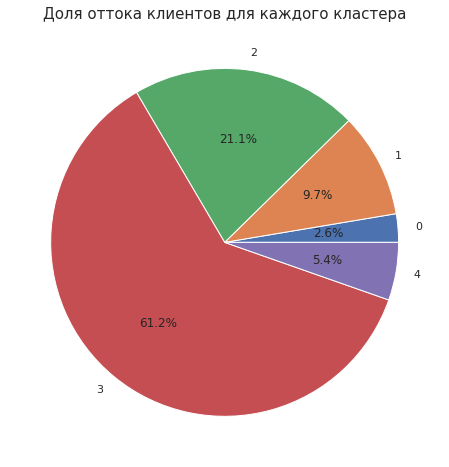

In [30]:
plt.figure(figsize=(12, 8))
plt.pie(share_of_outflow, labels=share_of_outflow.index, autopct='%1.1f%%')
plt.title('Доля оттока клиентов для каждого кластера', fontsize=15)
plt.show()

### Вывод

Кластеры 0 и 4 демонстрируют лучшие показатели по оттоку клиентов - 2,6% и 5,4% соответственно. Их ключевые черты помогут создать портрет нашего “идеального” лояльного клиента: это человек в возрасте 30 лет и старше, проживающий рядом с фитнес-центром, посещающий зал 2-3 раза в неделю, любитель групповых занятий и дополнительных услуг, а также владелец годового абонемента, часто сотрудник компании-партнера.

Наихудшие показатели у кластеров 3 и 2 - 61,2% и 21,1% соответственно. Их ключевые черты помогут создать портрет потенциально отточного клиента: это человек моложе 30 лет, проживающий далеко от клуба, посещающий клуб не чаще раза в неделю, обладатель краткосрочного абонемента и не склонный к групповым занятиям.

## Общие выводы и рекомендации по работе с клиентами

В ходе проекта было проделанно следующее:
- Предобработка данных: 
      1) Привели названия столбцов к нижнему регистру.
      2) В столбце month_to_end_contract поменяли тип данных.
- Провели исследовательский анализ EDA:
      1) Проаназировали признаки и группы оставшиеся-ушедшие.
      2) Выявили признаки не влияющие на отток: пол и наличие телефона в анкете.
      3) Выявили сильно коррелируют между собой пары признаков. Удалили один из признаков в паре.
- Построили модель прогнозирования оттока клиентов:
      1) Разделили данные на обучающую и валидационную выборку функцией train_test_split().
      2) Обучили модель на train-выборке двумя способами:
            1) логистической регрессией,
            2) случайным лесом.
      3) Оценили метрики accuracy, precision и recall для обеих моделей на валидационной выборке.
      4) Обе модели показали себя неплохо. Но модель логистической регресси немного лучше.
- Провели кластеризацию клиентов:
      1) Разбили данные на 5 кластеров.
      2) На основе анализа кластеров создали портрет:
            а) “идеального” лояльного клиента: это человек в возрасте 30 лет и старше, проживающий рядом с фитнес-центром, посещающий зал 2-3 раза в неделю, любитель групповых занятий и дополнительных услуг, а также владелец годового абонемента, часто сотрудник компании-партнера;
            б) потенциально отточного клиента: это человек моложе 30 лет, проживающий далеко от клуба, посещающий клуб не чаще раза в неделю, обладатель краткосрочного абонемента и не склонный к групповым занятиям.
            
**Рекомендации:**
- Продолжать и развивать акцию «Приведи друга», а также укреплять партнёрские программы.
- Стимулировать клиентов к приобретению абонементов на 6-12 месяцев. Активно продвигать и рекомендовать групповые занятия.
- Расширять спектр дополнительных услуг, чтобы повысить их привлекательность для клиентов.
- Поощрять клиентов за регулярное посещение фитнес-центра более двух раз в неделю.
- Сосредоточиться на привлечении целевой аудитории: людей в возрасте 30 лет и старше, проживающих или работающих в районе фитнес-центра.